In [3]:
import numpy as np

In [4]:
##code to generate irrational planes from hyperbolic matrices.
def hyperbolic_matrix(dim,rand = False):
    #returns a random, dim dimensional symmetric hyperbolic matrix
    U = np.eye(dim)
    if not rand:
        for i in range(dim):
            for j in range(dim):
                if i < j:
                    U[i][j] = 1

    else:
        for i in range(dim):
            for j in range(dim):
                if i < j:
                    U[i][j] = np.random.randint(1,high=5)
    L = U.T
    A = L @ U
    return A

def irrational_plane(A, dim):
    #returns a dim-1 dimensional eigen subspace of a dim dimensional hyperbolic matrix
    subspace_dim = dim - 1
    eigenvals,eigenvecs = np.linalg.eig(A)
    eigenvectors = []
    for i in range(dim):
        eigenvectors.append(eigenvecs[i]/np.linalg.norm(eigenvecs[i],ord=2))
    return eigenvectors[:subspace_dim]



In [6]:
A = hyperbolic_matrix(3)
print(A)
p = irrational_plane(A,3)
print(p)

[[1. 1. 1.]
 [1. 2. 2.]
 [1. 2. 3.]]
[array([-0.32798528, -0.73697623,  0.59100905]), array([-0.59100905, -0.32798528, -0.73697623])]


In [6]:
##code to project aperiodic points onto a plane
def point_projection(vectors,point):
    #returns the 2 dimensional representation of the point projection,
    #ie the coefficients multiplied by the eigenvectors to create the ortho projection
    projection = np.zeros(len(vectors))
    for i in range(len(vectors)):
        projection[i] = point.dot(vectors[i]) #coefficient
    return projection

def reducedDimensionMatrix(eig, dim):
    reddim = dim - 1
    r = np.eye(reddim)
    for i in range(reddim):
        for j in range(reddim):
            r[j,i] = eig[i][j]
    return r
def solveForZ(eig, matrix, x,dim):
    reddim = dim - 1
    rVector = np.linalg.solve(matrix,x)
    z=0
    for i in range(reddim):
        eig[i][reddim]
        z += rVector[i]*eig[i][reddim]
    return z
def reducedRankMatrix(eig, dim):
    for i in range(dim-1):
        for j in range(dim):
            r[j,i] = eig[i][j]
    return r

def aperiodic_points(R,dim,eig,borderSize,position):
    #x1<x2, y1<y1
    #input a range of integers to iterate over R, a dimension, a hyperbolic matrix, and a window size - get in return a set of aperiodic points within the range
    points = []
    patch_center = sum([position[i]*eig[i] for i in range(dim-1)]) #3d representation of position on plane
    patch_center = np.floor(patch_center).astype(int)
    rdm = reducedDimensionMatrix(eig, dim)
    r = np.eye(dim)
    x = patch_center[0]
    y = patch_center[1]
    
    for i in range(x-R,x+R):
        for j in range(y-R,y+R):
            x_=np.array([i,j])
            z = solveForZ(eig, rdm, x_,dim)
            borderFloor = np.floor((z-borderSize))
            borderRoof = np.floor((z+borderSize+1))
            for point in range( borderFloor.astype(int), borderRoof.astype(int)):
                if point > (z-borderSize) and point < (z+borderSize+1):
                    projected = point_projection(eig, np.array([i,j,point]))
                    points.append(projected)
    return points

In [22]:
#Return closest point with respect to x to thing in xPosition
def indexClosestPoint(listOfVectors, xPosition):
    size = len(listOfVectors)
    return auxIndexClosestPoint(listOfVectors, 0, size-1, xPosition)
def auxIndexClosestPoint(listOfVectors, nstart, nend, xPosition):
#    if (mend==nend and mstart==nstart):
#        print(listOfVectors[nstart],listOfVectors[nend], nstart, nend, xPosition, "\n")
    size = nend - nstart + 1
    if (size == 1):
        return nend
    if (size == 2):
        if ( (listOfVectors[nend][0]-xPosition)*(listOfVectors[nend][0]-xPosition) < (listOfVectors[nstart][0]-xPosition)*(listOfVectors[nstart][0]-xPosition)):
            return nend
        else:
            return nstart
    halfSize = (nstart + np.floor(size/2)).astype(int)
    if((listOfVectors[halfSize][0]) == xPosition):
        return halfSize
    if((listOfVectors[halfSize][0]) < xPosition):
        return auxIndexClosestPoint(listOfVectors, halfSize, nend, xPosition)
    return auxIndexClosestPoint(listOfVectors, nstart, halfSize, xPosition)


#Returns list of centers with which a colision occurs and corresponding list of projections of the center to a line spaned by the velocity
def posHitInArea(listOfVectors, position, velocity, radius,p):
    cp = indexClosestPoint(listOfVectors, position[0])
    it = 0
    length = len(listOfVectors)
    collisionList = []
    projectionList = []
    proj_matrix = np.outer(velocity,velocity)
    iter_direction = np.sign(velocity[0]).astype(int)
    radiusSquared = radius**2
    radiusDoubled = 2*radius

    if abs(velocity[1] + 1) < 0.02:
        k = 2
    else:
        k = 1

    if (velocity[0] == 0):
        itB = 0
        itA = 0
        before = listOfVectors[cp+itB]
        after = listOfVectors[cp+itA]
        while(before[0]-position[0]>-radius):
            if (cp+itB==length):
                break
            before = listOfVectors[cp+itB]
            currentVector = before
            newPosCenterSphere =  currentVector - position
            #We check that the sphere is close enough to collide and if so append
            projectionOfCenter = proj_matrix @ newPosCenterSphere
            centerToProjection = projectionOfCenter - newPosCenterSphere
            CTPLengthSQ = centerToProjection.dot(centerToProjection)
            if (CTPLengthSQ <= radiusSquared):
                collisionList.append( currentVector)
                projectionList.append(projectionOfCenter+position)
            itB+=1
        while(after[0]-position[0]<radius):
            if (cp+itA<0):
                break
            after = listOfVectors[cp+itA]
            currentVector = after
            newPosCenterSphere =  currentVector - position
            #We check that the sphere is close enough to collide and if so append
            projectionOfCenter = proj_matrix @ newPosCenterSphere
            centerToProjection = projectionOfCenter - newPosCenterSphere
            CTPLengthSQ = centerToProjection.dot(centerToProjection)
            if (CTPLengthSQ <= radiusSquared):
                collisionList.append( currentVector)
                projectionList.append(projectionOfCenter+position)
            itA-=1
            after = listOfVectors[cp+itA]
        return collisionList,projectionList
    while (cp+it<length and cp+it>=0):
        currentVector = listOfVectors[cp+it]
        #We move the plane so the electrton is in the center and this moves the circles to their according position
        newPosCenterSphere =  currentVector - position
        #We check that the sphere is close enough to collide and if so append
        projectionOfCenter = proj_matrix @ newPosCenterSphere
        centerToProjection = projectionOfCenter - newPosCenterSphere
        norm = np.linalg.norm(centerToProjection,ord=p)
        if (norm < radius):
            collisionList.append( currentVector)
            projectionList.append(projectionOfCenter+position)
        if (len(projectionList)>k):
            if iter_direction*(currentVector[0]-projectionList[k][0])>radiusDoubled:
                return collisionList,projectionList
        it += iter_direction
    #if (len(collisionList)>0):
    return collisionList,projectionList
    #raise Exception("No Collision")

In [18]:
''' order of function calls in the simulation:

the simulate diffusion function calls  the next_collision function at most max_bounces times
to calculate the position and velocity of the particle at the next collision.


the next_collision function needs to call a function 'find_point' (to be written) that returns a collision point, and the object
center corresponding to that collision point. it also calls the function collision that actually calculates the
new velocity resulting from the collision

the 'find_point' function will call the find_collision_point that, given a list of possible collision points
and their corresponding object centers, will return the collision point with the smallest norm to the position,
which is the actual collision point.

'''
##code to simulate the path of a particle through an aperiodic medium
def simulate_diffusion(radius,max_bounces,R,bordersize,p=2):
    #primary function to simulate particle collisions in media. input parameters: list of aperiodic points,
    #radius of obstacles, number of collisions to simulate to, and range of values to initialize position and
    #velocity within. This function continuously checks for the next particle collision until the stopping
    #criteria have been met, and returns a list of the position and velocity of the particle at each collision
    #it relies on a number of helper functions:
    n_bounces = 0
    dim = 3
    A = hyperbolic_matrix(dim)
    eigenvecs = irrational_plane(A,dim)
    
    results = np.zeros((2501,2))
    position = np.random.uniform(-1000,1000,2)
    velocity = np.random.uniform(-R,R,2)
    velocity = velocity/np.linalg.norm(velocity)
    
    points = sortVecX(aperiodic_points(R,dim,eigenvecs,bordersize,position))
    length = len(points)
    
    for point in points:
        if np.linalg.norm((position-point)) < radius:
            diff = (position - point)
            scalar = radius - np.linalg.norm(diff) + 0.01
            position += scalar*diff
            break

    results[0] = position
    index = 1
    
    while n_bounces < max_bounces:
        n_bounces += 1
        if len(points) > length:
            points = sortVecX(aperiodic_points(R,dim,eigenvecs,bordersize,position))
        (position,velocity,results,points,index) = next_collision(position,velocity,radius,results,points,R,dim,eigenvecs,bordersize,n_bounces,index,p)
        #print("num bounces: ", n_bounces)
    return results

def next_collision(position,velocity,radius,results,points,R,dim,eig,bordersize,n_bounces,index,p):
        #given a position, velocity and number of bounces, finds the next collision in the simulation
        collision_point,obj_center = find_collision_point(position,velocity,points,radius,p)
        
        i = 0
        while len(collision_point) == 0:
            points = sortVecX(aperiodic_points(R+i,dim,eig,bordersize,position))
            collision_point,obj_center = find_collision_point(position,velocity,points,radius,p)
            i += 2
        '''
        tan = np.array([collision_point[0]**(p-1),collision_point[1]**(p-1)])
        tan /= np.linalg.norm(tan,ord=p)
        #perp = (obj_center-collision_point)/radius
        if tan[0] != 0:
            perp = np.array([-(tan[1]/tan[0]),1])
        else:
            perp = np.array([1,-(tan[0]/tan[1])])
        perp /= np.linalg.norm(perp, ord=p)


        velocity_new = -(velocity.dot(tan)*tan - velocity.dot(perp)*perp)'''
        perp = (obj_center-collision_point)/radius
        if perp[0] != 0:
            ortho_perp = np.array([-(perp[1]/perp[0]),1])
        else:
            ortho_perp = np.array([1,-(perp[0]/perp[1])])
        ortho_perp /= np.linalg.norm(ortho_perp)
        #print('perpendicular to tangent of circle', perp)
        #print('tangent to circle', ortho_perp)

        velocity_new = -(velocity.dot(perp)*perp - velocity.dot(ortho_perp)*ortho_perp)
        #print('new velocity before normalization', velocity_new)
        position_new = collision_point

        velocity_new = velocity_new/np.linalg.norm(velocity_new)
        #print('new velocity after normalization', velocity_new)
        #print('new position', position_new)
        
        if n_bounces > 4500000:
            if (n_bounces)%200 == 0:
                results[index] = position_new
                index += 1
        
        return(position_new,velocity_new,results,points,index)

def sortVecX(vectors):
    #sorts list of points by x value in ascending order
    return sorted(vectors, key=lambda v: v[0])

def sortVecY(vectors):
    #sorts list of points by y value in ascending order
    return sorted(vectors, key=lambda v: v[1])

def find_collision_point(position, velocity,points,radius,p):
    #finds the next point of collision for the particle. calls the posHitInArea function to
    #generate list of possible object centers resulting in collisions, calculates collision points,
    #and returns the closest one to the current position.
    obj_centers,projections = posHitInArea(points,position,velocity,radius,p)
    centers_new = []
    possible_collisions = []
    radius_squared = radius**2
    for i in range(len(obj_centers)):
        center = obj_centers[i]
        projection = projections[i]
        a = np.sqrt(np.abs(radius**2-(center-projection).dot((center-projection))))
        collision_point_1 = projection + a*velocity
        collision_point_2 = projection - a*velocity
        if not (np.isclose(position,collision_point_1)).all() and not (np.isclose(position,collision_point_2)).all():
            if np.sign(collision_point_1[0] - position[0]) == np.sign(velocity[0]) and np.sign(collision_point_1[1] - position[1]) == np.sign(velocity[1]):
                centers_new.append(center)
                centers_new.append(center)
                possible_collisions.append(collision_point_1)
                possible_collisions.append(collision_point_2)
                
        
    if not possible_collisions:
        collision = np.array([])
        center = np.array([])
        return(collision,center)
    collision = possible_collisions[0]
    center = centers_new[0]
    for i in range(len(possible_collisions)):
        if (position-possible_collisions[i]).dot((position-possible_collisions[i])) < (position-collision).dot((position-collision)):
            collision = possible_collisions[i]
            center = centers_new[i]
    return (collision,center)

In [19]:
import time
radius = 0.3
max_bounces = 1000
R = 3
borderSize = 2

start = time.time()
results = simulate_diffusion(radius,max_bounces,R,borderSize,p=6)
end = time.time()
print("time to simulate {} collisions: ".format(str(len(results[0])-1)), end - start)

IndexError: index 2 is out of bounds for axis 0 with size 2

576


<Figure size 1080x1080 with 0 Axes>

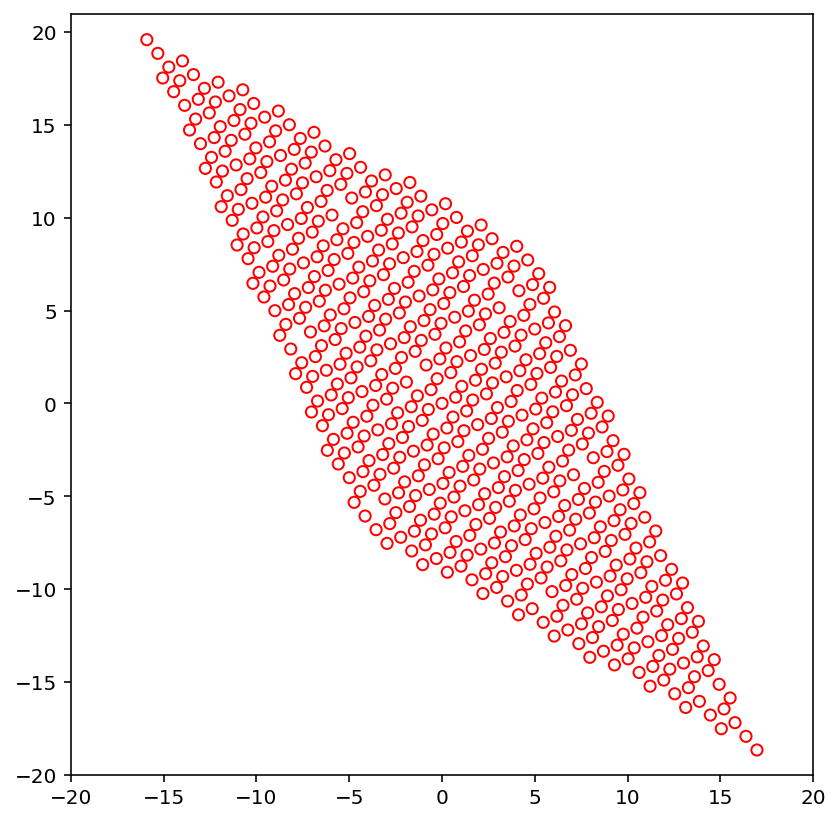

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

R = 6
dim = 3
A = hyperbolic_matrix(dim)
eigenvecs = irrational_plane(A,dim)
borderSize = 2
position = np.array([0,0])

points = aperiodic_points(R,dim,eigenvecs,borderSize,position)
print(len(points))
circles = [Circle(point,radius=0.3,color='r',fill=False) for point in points]
plt.figure(figsize=(15,15))
fig, ax = plt.subplots()
for circle in circles:
    ax.add_patch(circle)
ax.set_aspect('equal')
ax.set_xlim(-20,20)
ax.set_ylim(-20,21)
plt.show()

In [24]:
def simulate_diffusion_test(points,radius,max_bounces,position_init,velocity_init,R,bordersize,p=2):
    in_bounds = True
    n_bounces = 0
    points = sortVecX(points)
    
    dim = 3
    A = hyperbolic_matrix(dim)
    eigenvecs = irrational_plane(A,dim)
    
    positions = []
    velocities = []
    object_centers = []
    results = (positions,velocities,object_centers)

    position = position_init
    in_obstacle = True
    velocity = velocity_init
    velocity = velocity/np.linalg.norm(velocity)

    results[0].append(position)
    results[1].append(velocity)
    results[2].append(None)

    while n_bounces < max_bounces and in_bounds:
        (position,velocity,results,points) = next_collision_test(position,velocity,radius,results,points,R,dim,eigenvecs,bordersize,n_bounces,p)
        if not np.any(position):
            in_bounds = False
        n_bounces += 1
        
    return results

def next_collision_test(position,velocity,radius,results,points,R,dim,eig,bordersize,n_bounces,p):
        #given a position, velocity and number of bounces, finds the next collision in the simulation
        collision_point,obj_center = find_collision_point(position,velocity,points,radius,p)

        i = 0
        while len(collision_point) == 0:
            points = sortVecX(aperiodic_points(R+i,dim,eig,bordersize,position))
            collision_point,obj_center = find_collision_point(position,velocity,points,radius,p)
            i += 2

        '''
        perp = (obj_center-collision_point)/radius
        if perp[0] != 0:
            ortho_perp = np.array([-(perp[1]/perp[0]),1])
        else:
            ortho_perp = np.array([1,-(perp[0]/perp[1])])
        ortho_perp /= np.linalg.norm(ortho_perp)
        #print('perpendicular to tangent of circle', perp)
        #print('tangent to circle', ortho_perp)

        velocity_new = -(velocity.dot(perp)*perp - velocity.dot(ortho_perp)*ortho_perp)'''
        
        tan = np.array([collision_point[0]**(p-1),collision_point[1]**(p-1)])
        tan /= np.linalg.norm(tan,ord=p)
        #perp = (obj_center-collision_point)/radius
        if tan[0] != 0:
            perp = np.array([-(tan[1]/tan[0]),1])
        else:
            perp = np.array([1,-(tan[0]/tan[1])])
        perp /= np.linalg.norm(perp, ord=p)
        
        #print('new velocity before normalization', velocity_new)
        position_new = collision_point
        
        velocity_new = -(velocity.dot(tan)*tan - velocity.dot(perp)*perp)
        velocity_new = velocity_new/np.linalg.norm(velocity_new)
        #print('new velocity after normalization', velocity_new)
        #print('new position', position_new)

        results[0].append(position_new)
        results[1].append(velocity_new)
        results[2].append(obj_center)
        
        
        return(position_new,velocity_new,results,points)

test_points = [np.array([1,0])]
position_init = np.array([0,3])
velocity_init = np.array([0,-1])


results = simulate_diffusion_test(test_points,1,1,position_init,velocity_init,5,2)

print(results)

([array([0, 3]), array([0., 0.])], [array([ 0., -1.]), array([nan, nan])], [None, array([1, 0])])


/tmp/ipykernel_502/438881196.py:55: RuntimeWarning: invalid value encountered in true_divide
  tan /= np.linalg.norm(tan,ord=p)


In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time

positions = np.array(results[0]).transpose()
circles = [Circle(point,radius=1,color='r',fill=False) for point in test_points]
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
ax.scatter(positions[0],positions[1])
for i in range(len(positions[0])):
    ax.annotate(str(i),(positions[0,i],positions[1,i]), fontsize=12)
for circle in circles:
    ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

NameError: name 'results' is not defined

In [0]:
'''velocities = np.array(results[1]).transpose()
plt.scatter(velocities[0],velocities[1])
for i in range(len(positions[0])):
    plt.annotate(str(i),(velocities[0,i],velocities[1,i]), fontsize=12)'''